In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from sklearn.preprocessing import StandardScaler

# Statement of the problem:
The goal is to predict $f_d = [f_{d,0}, f_{d,1}, ... , f_{d,23}]$ given the previous history of the sequence $f$, i.e., $[f_1, f_2, ... f_{d-1}]$ in addition to other observations/high accuracy predictions $w_d$ (e.g. weather, load demand, electricity generation). Here, $f_d$ represents the set of 24 prices of electricity (in €/MWh) $f_{dh}$ for each hour $h$ of the day $d$. For instance, $f_{3}$ is the set of prices for the 3rd day of the series, and $f_{3,5}$ represents the price on this day at 5 am. While $f_{a}$ for $a < d$ is needed for the prediction, we can use $w_a$ for $a \le d$ as we assume $w_d$ to be an accurate weather forecast.

# Solution:

In this notebook, we will attempt a solution based on an LSTM model. The LSTM model will be trained on part of the sequences $f$ and $w$. Once trained, it will attempt to predict $f_d$, taking as immediate input $f_{d-1}$ and $w_d$ (of course, the the LSTM function itself will also depend on all past entries of $f$ and $w$ through its memory capability).

Restating, if the training is succesful we would ideally get LSTM$_{d-1}(f_{d-1},w_d) \approx f_d$.

In [7]:
energy_df_raw = pd.read_csv('./spain energy datasets/energy_dataset.csv')
weather_df_raw = pd.read_csv('./spain energy datasets/weather_features.csv')


### ENERGY DATAFRAME PREPROCESSING ###
energy_df = energy_df_raw.copy()
# Fill missing values with forecast
energy_df.fillna({'total load actual': energy_df['total load forecast']}, inplace = True)
# Keep only time and loads
energy_df = energy_df[['total load forecast', 'forecast solar day ahead',
 'forecast wind onshore day ahead', 'price day ahead']]

energy_df['residual load forecast'] = energy_df['total load forecast'] - energy_df['forecast solar day ahead'] - energy_df['forecast wind onshore day ahead']
energy_df.drop(columns = ['total load forecast', 'forecast solar day ahead', 
'forecast wind onshore day ahead'], inplace = True)

### WEATHER DATAFRAME PREPROCESSING ###
#weather_df = weather_df_raw.copy()
# Keep only time, temperature and city
#weather_df = weather_df[['dt_iso','temp','city_name']]
# There are duplicates in date and city, so we drop them
#weather_df = weather_df.drop_duplicates(subset = ['dt_iso', 'city_name'])
# Now we pivot the dataframe with respect to the city_name label
#weather_df = weather_df.pivot(index = 'dt_iso', columns = 'city_name',
#        values = [col for col in weather_df.columns if col not in ['dt_iso', 'city_name']])

# Province Population Dictionary, measured in millions of people (in the case of Bilbao, the entire Basque Country pop is taken because provices there are small)
#population_dict = {'Madrid': 7.058, ' Barcelona': 5.878, 'Valencia': 2.606, 'Seville': 1.973, 'Bilbao': 2.208}
#population_weights_dict = population_dict.copy()
#for key, value in population_weights_dict.items():
#  population_weights_dict[key] = value/sum(population_dict.values())

# Convert temperatures to a weighted sum
#weather_df = pd.DataFrame((weather_df['temp']*population_weights_dict).sum(axis = 1))
#weather_df.columns = ['temp']
#weather_df.reset_index(inplace = True)



#Shift temperature column 24 hours back so that we can align the load input from the current day with the temperature input for the upcoming day
energy_df['residual load forecast'] = energy_df['residual load forecast'].shift(-24)
# The previous shift creates 24 missing entries at the end of the 'temp' column, so we drop them
energy_df.dropna(inplace = True)

print(energy_df.head(24))



    price day ahead  residual load forecast
0             50.10                 13975.0
1             48.10                 12644.0
2             47.33                 11222.0
3             42.27                 11082.0
4             38.41                 10897.0
5             35.72                 11162.0
6             35.13                 11336.0
7             36.22                 12016.0
8             32.40                 12844.0
9             36.60                 13934.0
10            43.10                 15185.0
11            45.14                 15095.0
12            45.14                 13900.0
13            47.35                 13498.0
14            47.35                 13517.0
15            43.61                 12955.0
16            44.91                 12867.0
17            48.10                 14093.0
18            58.02                 18067.0
19            61.01                 21965.0
20            62.69                 23648.0
21            60.41             

In [21]:
class ElectricityDataset(Dataset):
  def __init__(self, df, all_scaler, look_back, horizon):
    # Only consider the variable 'total load actual'
    # We assume that the features used for the LSTM start at the first entry of df and are given by
    self.data = all_scaler.transform(df.to_numpy())
    self.scaler = all_scaler
    self.look_back = look_back
    self.horizon = horizon
    self.length = (len(df)- look_back) //horizon



  def __len__(self):
    return self.length

  def __getitem__(self, idx):
    assert idx >= 0, 'Index out of bounds'
    assert idx <= self.length, 'Index out of bounds'

    X = self.data[self.horizon*idx:self.horizon*idx + self.look_back]
    y = self.data[:, 0][self.horizon*idx + self.look_back:self.horizon*(idx+1) + self.look_back].reshape(-1,1)


    return torch.tensor(X, dtype = torch.float32), torch.tensor(y, dtype = torch.float32)



look_back = 24
horizon = 2

# Split data into training and testing dataframes
train_ratio = 0.7
train_size = int(train_ratio * len(energy_df))

# This is the first index, with respect to preprocessed_df, from which test data can be extracted:
first_test_idx = ((train_size- look_back) //horizon)*horizon + look_back



train_df = energy_df[:train_size]
test_df = energy_df[first_test_idx:]

# Create Standard Scaler and fit to training data
all_scaler = StandardScaler()
all_scaler.fit(train_df.to_numpy())
load_scaler = StandardScaler()
load_scaler.fit(train_df['price day ahead'].to_numpy().reshape(-1,1))


# Create training and testing datasets and dataloaders
train_ds = ElectricityDataset(train_df, all_scaler, look_back, horizon)
test_ds = ElectricityDataset(test_df, all_scaler, look_back, horizon)

train_loader = DataLoader(train_ds, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_ds, batch_size = 64, shuffle = False)

n_features = train_ds[0][0].shape[1]
print(f'Number of features = {n_features}')
train_df.drop(columns = ['price day ahead']).head()

Number of features = 2


,residual load forecast
0,13975.0
1,12644.0
2,11222.0
3,11082.0
4,10897.0


## Create models

We create an LSTM and GRU model to predict the load.

In [22]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.output_size = output_size

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]).reshape(-1,self.output_size,1)
        return out

class CustomGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomGRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.output_size = output_size

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :]).reshape(-1,self.output_size,1)
        return out


model_LSTM = CustomLSTM(n_features, hidden_size = 64, output_size = horizon)
model_GRU = CustomGRU(n_features, hidden_size = 64, output_size = horizon)

## Train models

In [23]:
# Identify training device and move model to device
#device = torch.device("cpu")
#model  = model.to(device)


# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer_LSTM = torch.optim.Adam(model_LSTM.parameters(), lr=10**(-3))
optimizer_GRU = torch.optim.Adam(model_GRU.parameters(), lr=10**(-3))

# Training loop
epochs = 150


train_loss_list_LSTM = []
test_loss_list_LSTM = []
train_loss_list_GRU = []
test_loss_list_GRU = []

epoch_list = []

for epoch in range(epochs):
    model_LSTM.train()
    model_GRU.train()

    train_loss_LSTM = 0.0
    train_loss_GRU = 0.0
    
    for features, labels in train_loader:
        optimizer_LSTM.zero_grad()
        outputs_LSTM = model_LSTM(features)
        optimizer_GRU.zero_grad()
        outputs_GRU = model_GRU(features)

        loss_LSTM = criterion(outputs_LSTM, labels)
        loss_GRU = criterion(outputs_GRU, labels)
        
        loss_LSTM.backward()
        loss_GRU.backward()

        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)

        optimizer_LSTM.step()
        optimizer_GRU.step()
        train_loss_LSTM += loss_LSTM.item()
        train_loss_GRU += loss_GRU.item()


    model_LSTM.eval()
    model_GRU.eval()
    
    test_loss_LSTM = 0.0
    test_loss_GRU = 0.0 
    
    with torch.no_grad():
        for features, labels in test_loader:
            outputs_LSTM = model_LSTM(features)
            loss_LSTM = criterion(outputs_LSTM, labels)
            test_loss_LSTM += loss_LSTM.item()

            outputs_GRU = model_GRU(features)
            loss_GRU = criterion(outputs_GRU, labels)
            test_loss_GRU += loss_GRU.item()



    epoch_list.append(epoch)
    train_loss_list_LSTM.append(train_loss_LSTM/len(train_loader))
    test_loss_list_LSTM.append(test_loss_LSTM/len(test_loader))
    train_loss_list_GRU.append(train_loss_GRU/len(train_loader))
    test_loss_list_GRU.append(test_loss_GRU/len(test_loader))



    print(f"Epoch {epoch+1}/{epochs} - LSTM Train Loss: {train_loss_LSTM/len(train_loader):.4f} - LSTM Test Loss: {test_loss_LSTM/len(test_loader):.4f}")
    print(f"Epoch {epoch+1}/{epochs} - GRU Train Loss: {train_loss_GRU/len(train_loader):.4f} - GRU Test Loss: {test_loss_GRU/len(test_loader):.4f}\n")

Epoch 1/150 - LSTM Train Loss: 0.4224 - LSTM Test Loss: 0.2936
Epoch 1/150 - GRU Train Loss: 0.3232 - GRU Test Loss: 0.1745

Epoch 2/150 - LSTM Train Loss: 0.1900 - LSTM Test Loss: 0.1322
Epoch 2/150 - GRU Train Loss: 0.1360 - GRU Test Loss: 0.1119

Epoch 3/150 - LSTM Train Loss: 0.1117 - LSTM Test Loss: 0.0996
Epoch 3/150 - GRU Train Loss: 0.0989 - GRU Test Loss: 0.0957

Epoch 4/150 - LSTM Train Loss: 0.0904 - LSTM Test Loss: 0.0821
Epoch 4/150 - GRU Train Loss: 0.0875 - GRU Test Loss: 0.0865

Epoch 5/150 - LSTM Train Loss: 0.0784 - LSTM Test Loss: 0.0755
Epoch 5/150 - GRU Train Loss: 0.0822 - GRU Test Loss: 0.0813

Epoch 6/150 - LSTM Train Loss: 0.0718 - LSTM Test Loss: 0.0713
Epoch 6/150 - GRU Train Loss: 0.0789 - GRU Test Loss: 0.0779

Epoch 7/150 - LSTM Train Loss: 0.0682 - LSTM Test Loss: 0.0690
Epoch 7/150 - GRU Train Loss: 0.0764 - GRU Test Loss: 0.0755

Epoch 8/150 - LSTM Train Loss: 0.0657 - LSTM Test Loss: 0.0673
Epoch 8/150 - GRU Train Loss: 0.0741 - GRU Test Loss: 0.0735



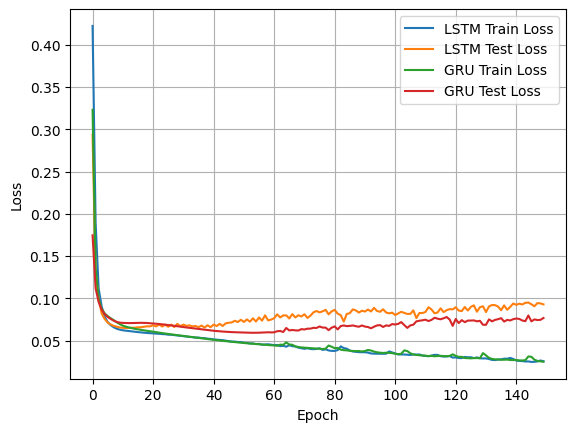

In [24]:
plt.plot(epoch_list, train_loss_list_LSTM, label = 'LSTM Train Loss')
plt.plot(epoch_list, test_loss_list_LSTM, label = 'LSTM Test Loss')
plt.plot(epoch_list, train_loss_list_GRU, label = 'GRU Train Loss')
plt.plot(epoch_list, test_loss_list_GRU, label = 'GRU Test Loss')


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

## Plot Prediction Sample and give MAPE

The MAPE (Mean Absolute Percentage Error) is given by the formula

$$MAPE= \frac{100}{T}\sum_{t=0}^T \left|\frac{f_t - \bar{f}_t}{f_t}\right|,$$
where $\bar{f}_t$ are the predicted values and $f_t$ are the observed values.

In [25]:
predict_ds = ElectricityDataset(energy_df, all_scaler, look_back, horizon)
predict_dl = DataLoader(predict_ds, batch_size = 1, shuffle = False)
obs = np.array([])
preds_LSTM = np.array([])
preds_GRU = np.array([])
with torch.no_grad():
  for X, y in predict_dl:
    obs = np.append(obs, load_scaler.inverse_transform(y.reshape(-1,1)))
    preds_LSTM = np.append(preds_LSTM, load_scaler.inverse_transform(model_LSTM(X).reshape(-1,1)))
    preds_GRU = np.append(preds_GRU, load_scaler.inverse_transform(model_GRU(X).reshape(-1,1)))

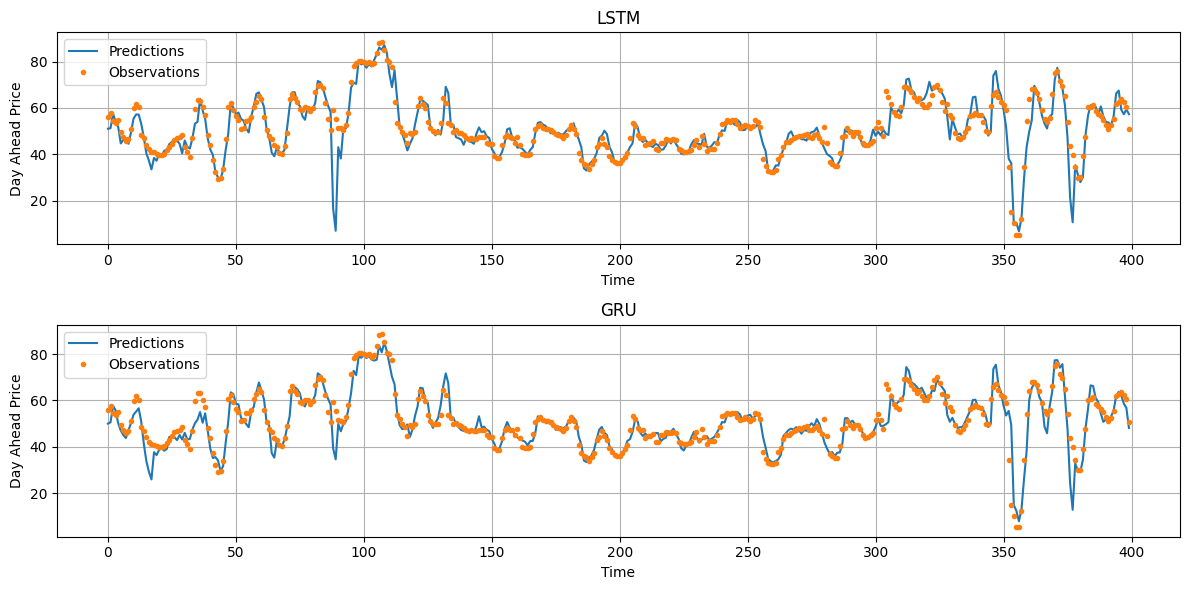

In [26]:
start_offset = 200
end_offset = 600

fig, ax = plt.subplots(2,1, figsize=(12, 6))
ax[0].plot(preds_LSTM[first_test_idx+start_offset:first_test_idx+end_offset], label = 'Predictions')
ax[0].plot(obs[first_test_idx+start_offset:first_test_idx+end_offset], ls = '', marker = '.', label = 'Observations')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Day Ahead Price')
ax[0].set_title('LSTM')
ax[0].grid()
ax[0].legend() 

ax[1].plot(preds_GRU[first_test_idx+start_offset:first_test_idx+end_offset], label = 'Predictions')
ax[1].plot(obs[first_test_idx+start_offset:first_test_idx+end_offset], ls = '', marker = '.', label = 'Observations')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Day Ahead Price')
ax[1].set_title('GRU')
ax[1].grid()
ax[1].legend()

plt.tight_layout()

In [27]:
MAPE_LSTM = np.mean(np.abs(1 - preds_LSTM[first_test_idx:]/obs[first_test_idx:]))*100
MAPE_GRU = np.mean(np.abs(1 - preds_GRU[first_test_idx:]/obs[first_test_idx:]))*100
print(f'MAPE of test dataset with LSTM predictions is {MAPE_LSTM:.4f}%.')
print(f'MAPE of test dataset with GRU predictions is {MAPE_GRU:.4f}%.')

MAPE of test dataset with LSTM predictions is 6.4158%.
MAPE of test dataset with GRU predictions is 5.9629%.


## Including Time-related Data:
First we proceed to train the LSTM with the same data as before, but also a variable that says whether the day is on the weekend

In [39]:
### ENERGY DATAFRAME PREPROCESSING ###
energy_df = energy_df_raw.copy()
# Fill missing values with forecast
energy_df.fillna({'total load actual': energy_df['total load forecast']}, inplace = True)
# Keep only time and loads
energy_df = energy_df[['time', 'total load actual', 'total load forecast']]



### WEATHER DATAFRAME PREPROCESSING ###
weather_df = weather_df_raw.copy()
# Keep only time, temperature and city
weather_df = weather_df[['dt_iso','temp','city_name']]
# There are duplicates in date and city, so we drop them
weather_df = weather_df.drop_duplicates(subset = ['dt_iso', 'city_name'])
# Now we pivot the dataframe with respect to the city_name label
weather_df = weather_df.pivot(index = 'dt_iso', columns = 'city_name',
        values = [col for col in weather_df.columns if col not in ['dt_iso', 'city_name']])

# Province Population Dictionary, measured in millions of people (in the case of Bilbao, the entire Basque Country pop is taken because provices there are small)
population_dict = {'Madrid': 7.058, ' Barcelona': 5.878, 'Valencia': 2.606, 'Seville': 1.973, 'Bilbao': 2.208}
population_weights_dict = population_dict.copy()
for key, value in population_weights_dict.items():
  population_weights_dict[key] = value/sum(population_dict.values())

# Convert temperatures to a weighted sum
weather_df = pd.DataFrame((weather_df['temp']*population_weights_dict).sum(axis = 1))
weather_df.columns = ['temp']
weather_df.reset_index(inplace = True)


# CONCATENATE BOTH DATAFRAMES AND ADD WEEKEND BOOL VARIABLE
assert len(energy_df) == len(weather_df), 'The energy and weather dataframes have different lengths'
preprocessed_df = pd.concat([energy_df, weather_df[weather_df['dt_iso'].isin(energy_df['time'])]], axis = 1)

preprocessed_df['is_weekend'] = (pd.to_datetime(preprocessed_df['time'], format = 'ISO8601', utc = True).dt.dayofweek >= 5).astype(int)
preprocessed_df.drop(columns = ['dt_iso','time'], inplace = True)

#Shift temperature column 24 hours back so that we can align the load input from the current day with the temperature input for the upcoming day
preprocessed_df[['temp','is_weekend']] = preprocessed_df[['temp', 'is_weekend']].shift(-24)
# The previous shift creates 24 missing entries at the end of the 'temp' column, so we drop them
preprocessed_df.dropna(inplace = True)

print(preprocessed_df.head(24))

    total load actual  total load forecast        temp  is_weekend
0             25385.0              26118.0  273.985599         0.0
1             24382.0              24934.0  273.876766         0.0
2             22734.0              23515.0  273.268827         0.0
3             21286.0              22642.0  273.193631         0.0
4             20264.0              21785.0  273.197252         0.0
5             19905.0              21441.0  272.698875         0.0
6             20010.0              21285.0  272.676222         0.0
7             20377.0              21545.0  272.833251         0.0
8             20094.0              21443.0  274.848934         0.0
9             20637.0              21560.0  274.946072         0.0
10            22250.0              22824.0  275.532990         0.0
11            23547.0              23720.0  278.491024         0.0
12            24133.0              24180.0  281.726146         0.0
13            24713.0              24797.0  283.297792        

<Axes: >

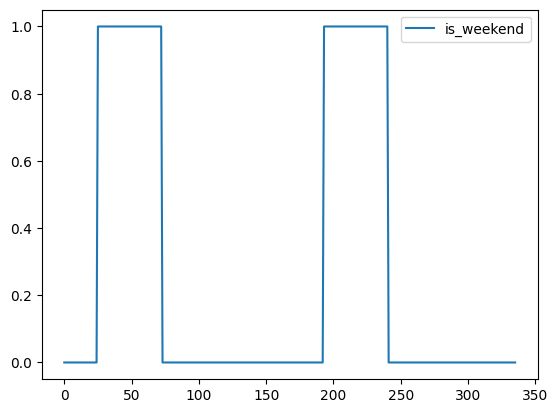

In [40]:
preprocessed_df[['is_weekend']].iloc[:14*24].plot()

In [41]:
train_df = preprocessed_df[:train_size]
test_df = preprocessed_df[first_test_idx:]

# Create Standard Scaler and fit to training data
all_scaler = StandardScaler()
all_scaler.fit(train_df.drop(columns = 'total load forecast').to_numpy())
load_scaler = StandardScaler()
load_scaler.fit(train_df['total load actual'].to_numpy().reshape(-1,1))


# Create training and testing datasets and dataloaders
train_ds = ElectricityDataset(train_df, all_scaler, look_back, horizon)
test_ds = ElectricityDataset(test_df, all_scaler, look_back, horizon)

train_loader = DataLoader(train_ds, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_ds, batch_size = 64, shuffle = False)

n_features = train_ds[0][0].shape[1]
print(f'Number of features = {n_features}')
train_df.drop(columns = ['total load forecast']).head()

Number of features = 3


,total load actual,temp,is_weekend
0,25385.0,273.985599,0.0
1,24382.0,273.876766,0.0
2,22734.0,273.268827,0.0
3,21286.0,273.193631,0.0
4,20264.0,273.197252,0.0


In [42]:
model = CustomLSTM(n_features, hidden_size = 64, output_size = horizon)

In [44]:
# Identify training device and move model to device
#device = torch.device("cpu")
#model  = model.to(device)


# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=10**(-3))

# Training loop
epochs = 250


train_loss_list = []
test_loss_list = []
epoch_list = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)

        loss = criterion(outputs, labels)
        loss.backward()

        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)

        optimizer.step()
        train_loss += loss.item()


    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            loss = criterion(outputs, labels)
            test_loss += loss.item()



    epoch_list.append(epoch)
    train_loss_list.append(train_loss/len(train_loader))
    test_loss_list.append(test_loss/len(test_loader))



    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss/len(train_loader):.4f} - Test Loss: {test_loss/len(test_loader):.4f}")

Epoch 1/250 - Train Loss: 0.0251 - Test Loss: 0.0565
Epoch 2/250 - Train Loss: 0.0189 - Test Loss: 0.0545
Epoch 3/250 - Train Loss: 0.0170 - Test Loss: 0.0540
Epoch 4/250 - Train Loss: 0.0159 - Test Loss: 0.0538
Epoch 5/250 - Train Loss: 0.0151 - Test Loss: 0.0537
Epoch 6/250 - Train Loss: 0.0145 - Test Loss: 0.0536
Epoch 7/250 - Train Loss: 0.0140 - Test Loss: 0.0536
Epoch 8/250 - Train Loss: 0.0135 - Test Loss: 0.0536
Epoch 9/250 - Train Loss: 0.0131 - Test Loss: 0.0536
Epoch 10/250 - Train Loss: 0.0128 - Test Loss: 0.0536
Epoch 11/250 - Train Loss: 0.0125 - Test Loss: 0.0535
Epoch 12/250 - Train Loss: 0.0122 - Test Loss: 0.0535
Epoch 13/250 - Train Loss: 0.0120 - Test Loss: 0.0535
Epoch 14/250 - Train Loss: 0.0118 - Test Loss: 0.0535
Epoch 15/250 - Train Loss: 0.0116 - Test Loss: 0.0535
Epoch 16/250 - Train Loss: 0.0114 - Test Loss: 0.0534
Epoch 17/250 - Train Loss: 0.0112 - Test Loss: 0.0535
Epoch 18/250 - Train Loss: 0.0110 - Test Loss: 0.0535
Epoch 19/250 - Train Loss: 0.0109 - T

KeyboardInterrupt: 

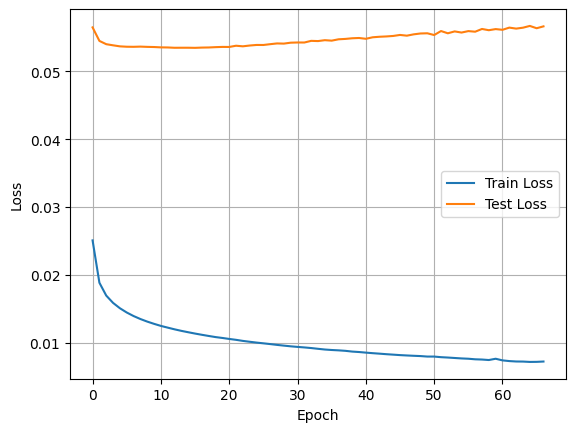

In [45]:
plt.plot(epoch_list, train_loss_list, label = 'Train Loss')
plt.plot(epoch_list, test_loss_list, label = 'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

In [46]:
predict_ds = ElectricityDataset(preprocessed_df, all_scaler, look_back, horizon)
predict_dl = DataLoader(predict_ds, batch_size = 1, shuffle = False)
obs = np.array([])
preds = np.array([])
with torch.no_grad():
  for X, y in predict_dl:
    obs = np.append(obs, load_scaler.inverse_transform(y.reshape(-1,1)))
    preds = np.append(preds, load_scaler.inverse_transform(model(X).reshape(-1,1)))

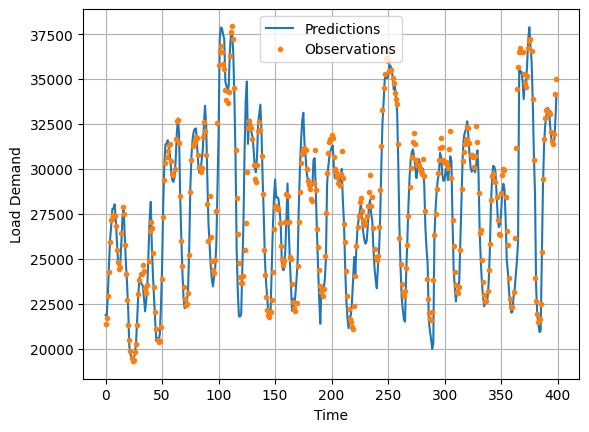

In [47]:
start_offset = 200
end_offset = 600
plt.plot(preds[first_test_idx+start_offset:first_test_idx+end_offset], label = 'Predictions')
plt.plot(obs[first_test_idx+start_offset:first_test_idx+end_offset], ls = '', marker = '.', label = 'Observations')
plt.xlabel('Time')
plt.ylabel('Load Demand')
plt.grid()
plt.legend()

In [48]:
MAPE = np.mean(np.abs(1 - preds[first_test_idx:]/obs[first_test_idx:]))*100
MAPE_given = np.mean(np.abs((1 - preprocessed_df['total load forecast'].iloc[first_test_idx:]/preprocessed_df['total load actual'].iloc[first_test_idx:]).to_numpy()))*100
print(f'MAPE of test dataset with LSTM predictions is {MAPE:.4f}%.')
print(f'MAPE of test dataset with predictions given in dataset is {MAPE_given:.4f}%.')

MASE of test dataset with LSTM predictions is 2.4386%.
MASE of test dataset with predictions given in dataset is 0.9594%.
